# Credit

This notebook is based on the following notebook by @yasufuminakama. I would like to take this opportunity to thank him.

Please vote for his notebook as well.

https://www.kaggle.com/yasufuminakama/cassava-resnext50-32x4d-starter-training

# Summary of this notebook

In this notebook, we are gonna build the nocall detector. (0:nocall, 1:somebird singing)

The output of the models would be probability value.

# input & output of this notebook

[input]

freefield1010 data

https://www.kaggle.com/startjapan/ff1010bird-duration7

[output]

Nocall detector models are outputted.

In [2]:
import os
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider(instance="ibm-q/open/main")
backend1 = provider.get_backend("ibm_perth")
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

ValueError: 'channel' can only be 'ibm_cloud' or 'ibm_quantum'

In [ ]:
import torch

class CFG:
    print_freq=100
    num_workers=4
    model_name= 'resnext50_32x4d'
    dim=(128, 281)
    scheduler='CosineAnnealingWarmRestarts'
    epochs=20
    #lr=1e-4
    lr=0.0001
    T_0=10 # for CosineAnnealingWarmRestarts
    min_lr=5e-7 # for CosineAnnealingWarmRestarts
    batch_size=32
    weight_decay=1e-6
    max_grad_norm=1000
    seed=42
    target_size=2
    target_col='hasbird'
    n_fold = 5
    pretrained = True
    #device = 'cpu'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd

train = pd.read_csv('/home/next/Quantum/Quantum-machine-learning-for-high-dimensional-data/input/rich_metadata.csv')
train.loc[train['hasbird']==0, 'filepath'] = '/home/next/Quantum/Quantum-machine-learning-for-high-dimensional-data/input/nocall/' + train.query('hasbird==0')['filename'] + '.npy'
train.loc[train['hasbird']==1, 'filepath'] = '/home/next/Quantum/Quantum-machine-learning-for-high-dimensional-data/input/bird/' + train.query('hasbird==1')['filename'] + '.npy'

train = train.dropna().reset_index(drop=True)

folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG.target_col]).size())

fold  hasbird
0     0          1151
      1           387
1     0          1151
      1           387
2     0          1151
      1           387
3     0          1151
      1           387
4     0          1151
      1           387
dtype: int64


In [ ]:
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

import warnings 
warnings.filterwarnings('ignore')

In [ ]:
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def get_confusion_matrix(y_true, y_pred):
    return confusion_matrix(y_true, y_pred)

@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_paths = df['filepath'].values
        self.labels = df['hasbird'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_paths[idx]
        file_path = file_name
        image = np.load(file_path)
        image = image.transpose(1,2,0)
        image = np.squeeze(image)
        image = np.stack((image,)*3, -1)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label

In [ ]:
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.Resize(CFG.dim[0], CFG.dim[1]),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.augmentations.transforms.JpegCompression(p=0.5),
            A.augmentations.transforms.ImageCompression(p=0.5, compression_type=A.augmentations.transforms.ImageCompression.ImageCompressionType.WEBP),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.dim[0], CFG.dim[1]),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

In [ ]:
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
# Necessary imports

import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, ZFeatureMap, EfficientSU2
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# Set seed for random generators
algorithm_globals.random_seed = 42

# we decompose the circuit for the QNN to avoid additional data copying
# Define and create QNN
nq=1
def create_qnn():
    feature_map = ZFeatureMap(nq, reps=2)
    ansatz = RealAmplitudes(nq, reps=1)
    qc = QuantumCircuit(nq)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn


qnn = create_qnn()

In [ ]:
from qiskit_machine_learning.connectors import TorchConnector
from torch import cat, no_grad, manual_seed

In [ ]:
class QuantumCustomResNext(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)  # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        x = self.qnn(x)
        #x = self.fc2(x)
        
        return x

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        
        optimizer.step()
        optimizer.zero_grad()
        global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  .format(
                   epoch+1, step+1, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   ))
    return losses.avg

def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step+1, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

In [ ]:
from torchsummary import summary

def train_loop(train_folds, valid_folds):

    LOGGER.info(f"========== training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    def get_scheduler(optimizer):
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = QuantumCustomResNext(CFG.model_name, pretrained=True)
    #model = CustomResNext(CFG.model_name, pretrained=True)
    model.to(CFG.device)
    
    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    #criterion = nn.CrossEntropyLoss()
    criterion = nn.NLLLoss()
    best_score = 0.
    best_loss = np.inf
    
    summary(model, (3, 128, 128))
    
    scores = []
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, CFG.device)
        
        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, CFG.device)
        valid_labels = valid_folds[CFG.target_col].values
        
        scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')
        
        scores.append(score)
        
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_best.pth')
    valid_folds[[str(c) for c in range(CFG.target_size)]] = check_point['preds']
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds, scores

In [ ]:
def main(fold):
    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.5f}')
    
    def get_result2(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        matrix = get_confusion_matrix(labels, preds)
        print('TN', matrix[0,0])
        print('FP', matrix[0,1])
        print('FN', matrix[1,0])
        print('TP', matrix[1,1])
    
    # train 
    train_folds = folds.query(f'fold!={fold}').reset_index(drop=True)
    valid_folds = folds.query(f'fold=={fold}').reset_index(drop=False)
    oof_df, scores = train_loop(train_folds, valid_folds)
    # CV result
    LOGGER.info(f"========== CV ==========")
    get_result(oof_df)
    get_result2(oof_df)
    # save result
    oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
    plt.plot([i for i in range(CFG.epochs)], scores)
    plt.title('valid score')
    plt.show()

========== training ==========


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]           8,192
       BatchNorm2d-6          [-1, 128, 32, 32]             256
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]           4,608
       BatchNorm2d-9          [-1, 128, 32, 32]             256
         Identity-10          [-1, 128, 32, 32]               0
             ReLU-11          [-1, 128, 32, 32]               0
         Identity-12          [-1, 128, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]          32,768
      BatchNorm2d-14          [-1, 256,

Epoch 1 - avg_train_loss: -0.7365  avg_val_loss: -0.7787  time: 46s
Epoch 1 - Accuracy: 0.8335500650195059
Epoch 1 - Save Best Score: 0.8336 Model


EVAL: [49/49] Data 0.000 (0.002) Elapsed 0m 2s (remain 0m 0s) Loss: -0.5838(-0.7787) 
Epoch: [2][1/192] Data 0.431 (0.431) Elapsed 0m 0s (remain 2m 35s) Loss: -0.7774(-0.7774) Grad: 20.2314  
Epoch: [2][101/192] Data 0.000 (0.005) Elapsed 0m 22s (remain 0m 20s) Loss: -0.8771(-0.7877) Grad: 7.3997  
Epoch: [2][192/192] Data 0.000 (0.002) Elapsed 0m 42s (remain 0m 0s) Loss: -0.7525(-0.7956) Grad: 6.2930  
EVAL: [1/49] Data 0.111 (0.111) Elapsed 0m 0s (remain 0m 8s) Loss: -0.7967(-0.7967) 


Epoch 2 - avg_train_loss: -0.7956  avg_val_loss: -0.8067  time: 45s
Epoch 2 - Accuracy: 0.8478543563068921
Epoch 2 - Save Best Score: 0.8479 Model


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 2s (remain 0m 0s) Loss: -0.5801(-0.8067) 
Epoch: [3][1/192] Data 0.232 (0.232) Elapsed 0m 0s (remain 1m 51s) Loss: -0.8212(-0.8212) Grad: 21.0660  
Epoch: [3][101/192] Data 0.000 (0.003) Elapsed 0m 21s (remain 0m 19s) Loss: -0.8960(-0.8149) Grad: 4.1817  
Epoch: [3][192/192] Data 0.000 (0.001) Elapsed 0m 41s (remain 0m 0s) Loss: -0.7591(-0.8186) Grad: 4.2191  
EVAL: [1/49] Data 0.127 (0.127) Elapsed 0m 0s (remain 0m 9s) Loss: -0.8100(-0.8100) 


Epoch 3 - avg_train_loss: -0.8186  avg_val_loss: -0.8236  time: 45s
Epoch 3 - Accuracy: 0.8608582574772432
Epoch 3 - Save Best Score: 0.8609 Model


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 3s (remain 0m 0s) Loss: -0.5765(-0.8236) 
Epoch: [4][1/192] Data 0.296 (0.296) Elapsed 0m 0s (remain 1m 55s) Loss: -0.8443(-0.8443) Grad: 20.6153  
Epoch: [4][101/192] Data 0.001 (0.003) Elapsed 0m 23s (remain 0m 21s) Loss: -0.8976(-0.8259) Grad: 13.8209  
Epoch: [4][192/192] Data 0.000 (0.002) Elapsed 0m 44s (remain 0m 0s) Loss: -0.7675(-0.8294) Grad: 7.2947  
EVAL: [1/49] Data 0.119 (0.119) Elapsed 0m 0s (remain 0m 9s) Loss: -0.8156(-0.8156) 


Epoch 4 - avg_train_loss: -0.8294  avg_val_loss: -0.8214  time: 48s
Epoch 4 - Accuracy: 0.8615084525357607
Epoch 4 - Save Best Score: 0.8615 Model


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 2s (remain 0m 0s) Loss: -0.6166(-0.8214) 
Epoch: [5][1/192] Data 0.320 (0.320) Elapsed 0m 0s (remain 2m 4s) Loss: -0.8506(-0.8506) Grad: 21.9507  
Epoch: [5][101/192] Data 0.000 (0.003) Elapsed 0m 24s (remain 0m 22s) Loss: -0.9080(-0.8361) Grad: 13.7824  
Epoch: [5][192/192] Data 0.000 (0.002) Elapsed 0m 46s (remain 0m 0s) Loss: -0.7651(-0.8399) Grad: 2.4369  
EVAL: [1/49] Data 0.144 (0.144) Elapsed 0m 0s (remain 0m 10s) Loss: -0.8323(-0.8323) 


Epoch 5 - avg_train_loss: -0.8399  avg_val_loss: -0.8306  time: 49s
Epoch 5 - Accuracy: 0.8673602080624188
Epoch 5 - Save Best Score: 0.8674 Model


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 2s (remain 0m 0s) Loss: -0.5903(-0.8306) 
Epoch: [6][1/192] Data 0.328 (0.328) Elapsed 0m 0s (remain 2m 12s) Loss: -0.8504(-0.8504) Grad: 24.3119  
Epoch: [6][101/192] Data 0.000 (0.003) Elapsed 0m 24s (remain 0m 22s) Loss: -0.8960(-0.8425) Grad: 16.2098  
Epoch: [6][192/192] Data 0.000 (0.002) Elapsed 0m 46s (remain 0m 0s) Loss: -0.7649(-0.8461) Grad: 2.1695  
EVAL: [1/49] Data 0.111 (0.111) Elapsed 0m 0s (remain 0m 8s) Loss: -0.8240(-0.8240) 


Epoch 6 - avg_train_loss: -0.8461  avg_val_loss: -0.8367  time: 50s
Epoch 6 - Accuracy: 0.8725617685305592
Epoch 6 - Save Best Score: 0.8726 Model


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 2s (remain 0m 0s) Loss: -0.5903(-0.8367) 
Epoch: [7][1/192] Data 0.260 (0.260) Elapsed 0m 0s (remain 1m 37s) Loss: -0.8807(-0.8807) Grad: 20.1816  
Epoch: [7][101/192] Data 0.000 (0.003) Elapsed 0m 24s (remain 0m 22s) Loss: -0.8938(-0.8507) Grad: 9.4757  
Epoch: [7][192/192] Data 0.000 (0.002) Elapsed 0m 46s (remain 0m 0s) Loss: -0.7690(-0.8541) Grad: 2.2076  
EVAL: [1/49] Data 0.122 (0.122) Elapsed 0m 0s (remain 0m 9s) Loss: -0.8379(-0.8379) 


Epoch 7 - avg_train_loss: -0.8541  avg_val_loss: -0.8395  time: 49s
Epoch 7 - Accuracy: 0.8771131339401821
Epoch 7 - Save Best Score: 0.8771 Model


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 2s (remain 0m 0s) Loss: -0.6366(-0.8395) 
Epoch: [8][1/192] Data 0.327 (0.327) Elapsed 0m 0s (remain 2m 0s) Loss: -0.8913(-0.8913) Grad: 18.0141  
Epoch: [8][101/192] Data 0.000 (0.003) Elapsed 0m 26s (remain 0m 23s) Loss: -0.9005(-0.8556) Grad: 11.2670  
Epoch: [8][192/192] Data 0.000 (0.002) Elapsed 0m 49s (remain 0m 0s) Loss: -0.7827(-0.8587) Grad: 2.0695  
EVAL: [1/49] Data 0.120 (0.120) Elapsed 0m 0s (remain 0m 9s) Loss: -0.8404(-0.8404) 


Epoch 8 - avg_train_loss: -0.8587  avg_val_loss: -0.8436  time: 52s
Epoch 8 - Accuracy: 0.8771131339401821


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 3s (remain 0m 0s) Loss: -0.6275(-0.8436) 
Epoch: [9][1/192] Data 0.297 (0.297) Elapsed 0m 0s (remain 2m 5s) Loss: -0.8658(-0.8658) Grad: 21.9563  
Epoch: [9][101/192] Data 0.000 (0.003) Elapsed 0m 30s (remain 0m 27s) Loss: -0.9035(-0.8583) Grad: 13.7532  
Epoch: [9][192/192] Data 0.000 (0.002) Elapsed 0m 57s (remain 0m 0s) Loss: -0.7839(-0.8620) Grad: 6.4165  
EVAL: [1/49] Data 0.163 (0.163) Elapsed 0m 0s (remain 0m 12s) Loss: -0.8493(-0.8493) 


Epoch 9 - avg_train_loss: -0.8620  avg_val_loss: -0.8452  time: 61s
Epoch 9 - Accuracy: 0.8745123537061118


EVAL: [49/49] Data 0.000 (0.004) Elapsed 0m 3s (remain 0m 0s) Loss: -0.5978(-0.8452) 
Epoch: [10][1/192] Data 0.404 (0.404) Elapsed 0m 0s (remain 2m 34s) Loss: -0.8956(-0.8956) Grad: 16.9309  
Epoch: [10][101/192] Data 0.000 (0.004) Elapsed 0m 29s (remain 0m 26s) Loss: -0.9142(-0.8592) Grad: 10.5544  
Epoch: [10][192/192] Data 0.000 (0.002) Elapsed 0m 51s (remain 0m 0s) Loss: -0.7837(-0.8627) Grad: 3.4839  
EVAL: [1/49] Data 0.120 (0.120) Elapsed 0m 0s (remain 0m 8s) Loss: -0.8507(-0.8507) 


Epoch 10 - avg_train_loss: -0.8627  avg_val_loss: -0.8453  time: 54s
Epoch 10 - Accuracy: 0.8797139141742523
Epoch 10 - Save Best Score: 0.8797 Model


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 2s (remain 0m 0s) Loss: -0.6002(-0.8453) 
Epoch: [11][1/192] Data 0.357 (0.357) Elapsed 0m 0s (remain 2m 18s) Loss: -0.8971(-0.8971) Grad: 13.2976  
Epoch: [11][101/192] Data 0.000 (0.004) Elapsed 0m 22s (remain 0m 20s) Loss: -0.9251(-0.8539) Grad: 7.4028  
Epoch: [11][192/192] Data 0.000 (0.002) Elapsed 0m 41s (remain 0m 0s) Loss: -0.7793(-0.8544) Grad: 2.2012  
EVAL: [1/49] Data 0.121 (0.121) Elapsed 0m 0s (remain 0m 9s) Loss: -0.8355(-0.8355) 


Epoch 11 - avg_train_loss: -0.8544  avg_val_loss: -0.8354  time: 45s
Epoch 11 - Accuracy: 0.8719115734720416


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 2s (remain 0m 0s) Loss: -0.7108(-0.8354) 
Epoch: [12][1/192] Data 0.296 (0.296) Elapsed 0m 0s (remain 2m 32s) Loss: -0.8720(-0.8720) Grad: 23.1119  
Epoch: [12][101/192] Data 0.000 (0.003) Elapsed 0m 23s (remain 0m 21s) Loss: -0.8983(-0.8556) Grad: 8.3964  
Epoch: [12][192/192] Data 0.000 (0.002) Elapsed 0m 44s (remain 0m 0s) Loss: -0.7898(-0.8599) Grad: 6.0960  
EVAL: [1/49] Data 0.126 (0.126) Elapsed 0m 0s (remain 0m 10s) Loss: -0.8195(-0.8195) 


Epoch 12 - avg_train_loss: -0.8599  avg_val_loss: -0.8398  time: 47s
Epoch 12 - Accuracy: 0.8758127438231469


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 2s (remain 0m 0s) Loss: -0.7166(-0.8398) 
Epoch: [13][1/192] Data 0.296 (0.296) Elapsed 0m 0s (remain 1m 57s) Loss: -0.9149(-0.9149) Grad: 10.5423  
Epoch: [13][101/192] Data 0.000 (0.003) Elapsed 0m 22s (remain 0m 20s) Loss: -0.9031(-0.8667) Grad: 11.5473  
Epoch: [13][192/192] Data 0.000 (0.002) Elapsed 0m 41s (remain 0m 0s) Loss: -0.7879(-0.8702) Grad: 3.3170  
EVAL: [1/49] Data 0.145 (0.145) Elapsed 0m 0s (remain 0m 10s) Loss: -0.8316(-0.8316) 


Epoch 13 - avg_train_loss: -0.8702  avg_val_loss: -0.8517  time: 45s
Epoch 13 - Accuracy: 0.8842652795838751
Epoch 13 - Save Best Score: 0.8843 Model


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 2s (remain 0m 0s) Loss: -0.7843(-0.8517) 
Epoch: [14][1/192] Data 0.303 (0.303) Elapsed 0m 0s (remain 2m 4s) Loss: -0.9095(-0.9095) Grad: 12.9018  
Epoch: [14][101/192] Data 0.000 (0.003) Elapsed 0m 24s (remain 0m 22s) Loss: -0.9178(-0.8741) Grad: 13.5885  
Epoch: [14][192/192] Data 0.000 (0.002) Elapsed 0m 44s (remain 0m 0s) Loss: -0.7971(-0.8761) Grad: 7.4924  
EVAL: [1/49] Data 0.114 (0.114) Elapsed 0m 0s (remain 0m 9s) Loss: -0.8198(-0.8198) 


Epoch 14 - avg_train_loss: -0.8761  avg_val_loss: -0.8437  time: 48s
Epoch 14 - Accuracy: 0.88296488946684


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 3s (remain 0m 0s) Loss: -0.8067(-0.8437) 
Epoch: [15][1/192] Data 0.362 (0.362) Elapsed 0m 0s (remain 2m 6s) Loss: -0.9120(-0.9120) Grad: 9.9840  
Epoch: [15][101/192] Data 0.000 (0.004) Elapsed 0m 23s (remain 0m 21s) Loss: -0.8906(-0.8788) Grad: 19.1409  
Epoch: [15][192/192] Data 0.000 (0.002) Elapsed 0m 45s (remain 0m 0s) Loss: -0.8073(-0.8822) Grad: 2.3226  
EVAL: [1/49] Data 0.146 (0.146) Elapsed 0m 0s (remain 0m 10s) Loss: -0.8192(-0.8192) 


Epoch 15 - avg_train_loss: -0.8822  avg_val_loss: -0.8491  time: 48s
Epoch 15 - Accuracy: 0.8875162548764629
Epoch 15 - Save Best Score: 0.8875 Model


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 2s (remain 0m 0s) Loss: -0.7666(-0.8491) 
Epoch: [16][1/192] Data 0.265 (0.265) Elapsed 0m 0s (remain 2m 24s) Loss: -0.9362(-0.9362) Grad: 15.0934  
Epoch: [16][101/192] Data 0.000 (0.003) Elapsed 0m 24s (remain 0m 22s) Loss: -0.9193(-0.8842) Grad: 11.4318  
Epoch: [16][192/192] Data 0.000 (0.002) Elapsed 0m 46s (remain 0m 0s) Loss: -0.8059(-0.8880) Grad: 3.0828  
EVAL: [1/49] Data 0.142 (0.142) Elapsed 0m 0s (remain 0m 10s) Loss: -0.8196(-0.8196) 


Epoch 16 - avg_train_loss: -0.8880  avg_val_loss: -0.8474  time: 49s
Epoch 16 - Accuracy: 0.8920676202860858
Epoch 16 - Save Best Score: 0.8921 Model


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 2s (remain 0m 0s) Loss: -0.8202(-0.8474) 
Epoch: [17][1/192] Data 0.268 (0.268) Elapsed 0m 0s (remain 2m 5s) Loss: -0.8925(-0.8925) Grad: 20.7838  
Epoch: [17][101/192] Data 0.000 (0.003) Elapsed 0m 25s (remain 0m 23s) Loss: -0.9171(-0.8887) Grad: 13.8605  
Epoch: [17][192/192] Data 0.000 (0.002) Elapsed 0m 47s (remain 0m 0s) Loss: -0.8211(-0.8931) Grad: 2.4256  
EVAL: [1/49] Data 0.140 (0.140) Elapsed 0m 0s (remain 0m 10s) Loss: -0.8506(-0.8506) 


Epoch 17 - avg_train_loss: -0.8931  avg_val_loss: -0.8604  time: 51s
Epoch 17 - Accuracy: 0.8920676202860858


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 3s (remain 0m 0s) Loss: -0.7361(-0.8604) 
Epoch: [18][1/192] Data 0.350 (0.350) Elapsed 0m 0s (remain 2m 2s) Loss: -0.9197(-0.9197) Grad: 14.0211  
Epoch: [18][101/192] Data 0.000 (0.004) Elapsed 0m 24s (remain 0m 21s) Loss: -0.9166(-0.8922) Grad: 16.1350  
Epoch: [18][192/192] Data 0.000 (0.002) Elapsed 0m 44s (remain 0m 0s) Loss: -0.8198(-0.8963) Grad: 5.2898  
EVAL: [1/49] Data 0.130 (0.130) Elapsed 0m 0s (remain 0m 9s) Loss: -0.8421(-0.8421) 


Epoch 18 - avg_train_loss: -0.8963  avg_val_loss: -0.8617  time: 47s
Epoch 18 - Accuracy: 0.893368010403121
Epoch 18 - Save Best Score: 0.8934 Model


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 2s (remain 0m 0s) Loss: -0.7410(-0.8617) 
Epoch: [19][1/192] Data 0.309 (0.309) Elapsed 0m 0s (remain 1m 58s) Loss: -0.9277(-0.9277) Grad: 12.3564  
Epoch: [19][101/192] Data 0.000 (0.003) Elapsed 0m 23s (remain 0m 21s) Loss: -0.9276(-0.8944) Grad: 9.8481  
Epoch: [19][192/192] Data 0.000 (0.002) Elapsed 0m 43s (remain 0m 0s) Loss: -0.8184(-0.8989) Grad: 8.4787  
EVAL: [1/49] Data 0.156 (0.156) Elapsed 0m 0s (remain 0m 10s) Loss: -0.8551(-0.8551) 


Epoch 19 - avg_train_loss: -0.8989  avg_val_loss: -0.8635  time: 47s
Epoch 19 - Accuracy: 0.8907672301690507


EVAL: [49/49] Data 0.000 (0.004) Elapsed 0m 2s (remain 0m 0s) Loss: -0.7214(-0.8635) 
Epoch: [20][1/192] Data 0.306 (0.306) Elapsed 0m 0s (remain 1m 58s) Loss: -0.9203(-0.9203) Grad: 8.2810  
Epoch: [20][101/192] Data 0.000 (0.003) Elapsed 0m 23s (remain 0m 20s) Loss: -0.9298(-0.8974) Grad: 7.9783  
Epoch: [20][192/192] Data 0.000 (0.002) Elapsed 0m 42s (remain 0m 0s) Loss: -0.8177(-0.9009) Grad: 8.4521  
EVAL: [1/49] Data 0.124 (0.124) Elapsed 0m 0s (remain 0m 9s) Loss: -0.8527(-0.8527) 


Epoch 20 - avg_train_loss: -0.9009  avg_val_loss: -0.8639  time: 46s
Epoch 20 - Accuracy: 0.8907672301690507
========== CV ==========
Score: 0.89337


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 2s (remain 0m 0s) Loss: -0.7200(-0.8639) 
TN 1124
FP 27
FN 137
TP 250


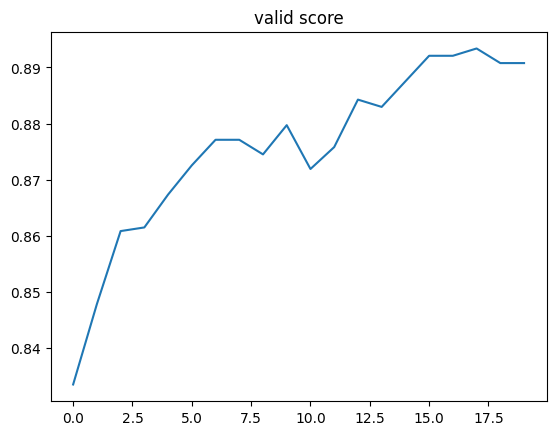

In [ ]:
if __name__ == '__main__':
    main(0)